# **Advanced DL and RL: Домашнее задание 3**

## Выполнил: **Русаков Д.Д.**
## Группа: **MADE-DS-32**

Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям.


## **Часть первая: перенос стиля при помощи pix2pix**

В этом задании мы будем реализовывать перенос стиля на paired данных. Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов

В первой части подразумевается реализация pix2pix архитектуры, т.е. генератора и дискриминатора, которые получают на вход условие в виде изображения исходного стиля


#### **Refernces:**
#### https://github.com/MistreanuIonutCosmin/ML-Path/blob/246b68ae1a23c24137ca1d2fd4b0cdfa31dcbd92/implementations/Pix2Pix.ipynb

#### https://github.com/vamsi3/pix2pix

#### https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

#### https://github.com/PaddlePaddle/PaddleGAN/blob/896939b259bABdbe758c0417540479477dcb4a8/docs/en_US/tutorials/pix2pix_cyclegan.md

In [1]:
import os
from math import floor
from matplotlib import pyplot as plt
from math import sqrt
import numpy as np
from PIL import Image
import torchvision as tv
import torch
import time



import glob
import random
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import datetime
import sys
from torch.autograd import Variable
# from visdom import Visdom
import torch.nn as nn
import torch.nn.functional as F
import itertools
from torch.utils.data import DataLoader


In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Global Hyper-parameters
batch_size = 32 # Colab буже 64 не берет, по видеопамяти падает
num_workers = 1
shuffle = False
image_with = 256
image_height = 256
num_epochs = 70
lr = 0.0002 # 2e-4
K = 2 #number of steps for the discriminator

### DataSet

In [4]:
# Download dataset      
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz

--2020-12-16 20:33:49--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.2’

facades.tar.gz.2    100%[===================>]  28.77M  74.1MB/s    in 0.4s    

2020-12-16 20:33:50 (74.1 MB/s) - ‘facades.tar.gz.2’ saved [30168306/30168306]



In [5]:
!tar -xf facades.tar.gz


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset_dir = 'facades'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [9]:
class FacadesDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, self.imgs[idx])
        img = np.array(Image.open(img_path).convert("RGB"))

        # split image to source and target
        h, w, d = img.shape
        w = w // 2
        real_image = img[:, :w, :]
        input_image = img[:, w:, :]

        # apply preprocessing transforms
        if self.transforms is not None:
            input_image = self.transforms(Image.fromarray(input_image))
            real_image = self.transforms(Image.fromarray(real_image))

        return input_image, real_image

    def __len__(self):
        return len(self.imgs)

transforms = tv.transforms.Compose([
    tv.transforms.Resize((268, 268)),
    tv.transforms.RandomCrop((image_with, image_height)),
    tv.transforms.Lambda(lambda img: (np.array(img) / 127.5) - 1), 
    tv.transforms.ToTensor(),
])

train_set = FacadesDataset(root=train_dir, transforms=transforms)
val_set = FacadesDataset(root=val_dir, transforms=transforms)
test_set = FacadesDataset(root=test_dir, transforms=transforms)

In [10]:
# Data Loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

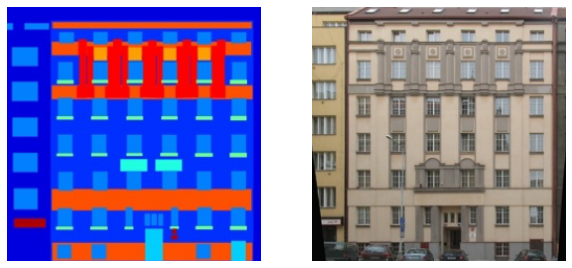

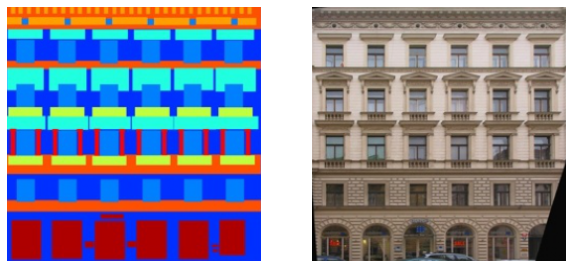

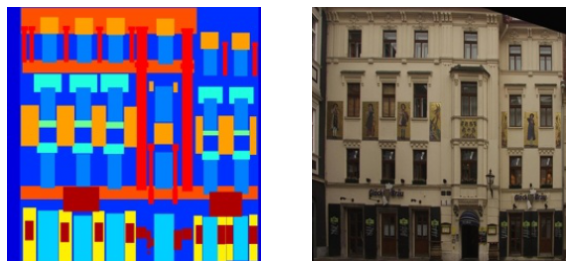

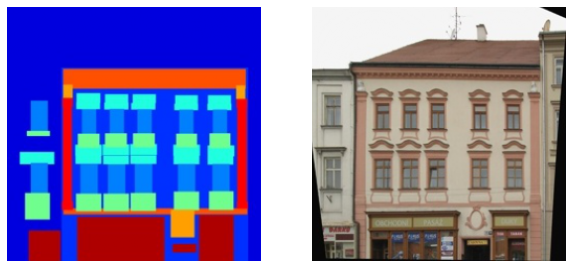

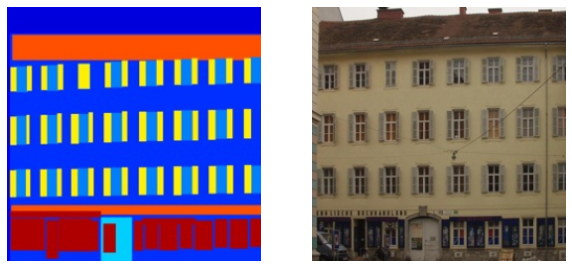

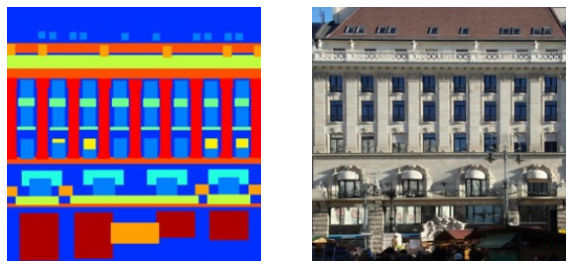

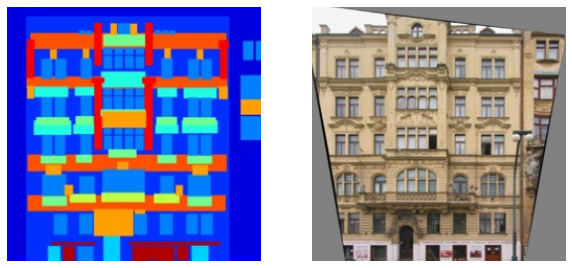

In [11]:
# Visualize Images

from matplotlib import pyplot as plt
from math import sqrt
%matplotlib inline

# load a batch

src_imgs, tgt_imgs = next(iter(test_loader))
for i in range(7):
# visualize batch
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

  ax1.axis("off")
  ax2.axis("off")

  ax1.imshow(np.transpose((src_imgs[i] + 1) / 2, (1, 2, 0)))
  ax2.imshow(np.transpose((tgt_imgs[i] + 1) / 2, (1, 2, 0)))

Ref:  https://habr.com/ru/post/323374/

      https://habr.com/ru/post/483310/

      https://habr.com/ru/post/278425/


pix2pix использует две нейронные сети, обучающиеся параллельно:


1. Генератор
2. Дискриминатор


Генератору на вход дается input image — она является дополнительным условием на то, что нужно сгенерировать. На ее основе генератор должен сгенерировать картинку на выход.

Дискриминатору — дается и input image, и то, что сгенерировал генератор (или, для positive examples — настоящая пара из тренировочного датасета), и он должен выдать является ли сгенерированная картинка настоящей или сгенерированной. Таким образом, если генератор будет генерировать картинку, не относящуюся к входной — дискриминатор должен это определить и отбросить.

Генератор является результатом итеративной тренировки этой пары сетей.


In [12]:
# Downsample Block

def ConvBlock(in_filters, out_filters, kernel, batch_norm, padding):
    if batch_norm:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters, 
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                bias=False,
                stride=2,
                padding=padding
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [13]:
# Upsample Block
def ConvTransBlock(in_filters, out_filters, kernel, dropout, padding):
    if dropout:
        return torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=in_filters,
                out_channels=out_filters,
                kernel_size=kernel,
                stride=2,
                bias=False,
                padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.Dropout2d(0.5),
            torch.nn.LeakyReLU(0.2)
        )
    else:
        return torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=in_filters,
                out_channels=out_filters,
                 kernel_size=kernel,
                 stride=2,
                 bias=False,
                 padding=padding
            ),
            torch.nn.BatchNorm2d(
                num_features=out_filters
            ),
            torch.nn.LeakyReLU(0.2)
        )

In [14]:
# Generator Class
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.unet_down = torch.nn.Sequential(
            ConvBlock(3, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            ConvBlock(256, 512, 4, True, 1), # (bs, 16, 16, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 8, 8, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 4, 4, 512)
            ConvBlock(512, 512, 4, True, 1), # (bs, 2, 2, 512)
            ConvBlock(512, 512, 4, True, 1) # (bs, 1, 1, 512)
        )
        
        self.unet_up = torch.nn.Sequential(
            ConvTransBlock(512, 512, 4, True, 1), # (bs, 2, 2, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 4, 4, 1024)
            ConvTransBlock(1024, 512, 4, True, 1), # (bs, 8, 8, 1024)
            ConvTransBlock(1024, 512, 4, False, 13), # (bs, 16, 16, 1024)
            ConvTransBlock(1024, 256, 4, False, 25), # (bs, 32, 32, 512)
            ConvTransBlock(512, 128, 4, False, 49), # (bs, 64, 64, 256)
            ConvTransBlock(256, 64, 4, False, 97) # (bs, 128, 128, 128)
        )
        
        self.last = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=3,
                kernel_size=2,
                stride=2,
                padding=0,
                bias=False
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, inputs):
        
        skips = []
        for layer in self.unet_down:
            outputs = layer(inputs)
            skips.append(outputs)
            inputs = outputs
        
        rev_skips = reversed(skips[:-1])  # notice down has one more layer than up path
        
        for layer, skip in zip(self.unet_up, rev_skips):
            outputs = layer(inputs)  # first layer in upward takes the output from down directly w/o concat
            inputs = torch.cat(
                (outputs, skip), 1
            )
        
        return self.last(inputs)

In [15]:
# Discriminator Class (Patch GAN)
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = torch.nn.Sequential( # (bs, 256, 256, 6)
            ConvBlock(6, 64, 4, False, 1), # (bs, 128, 128, 64)
            ConvBlock(64, 128, 4, True, 1), # (bs, 64, 64, 128)
            ConvBlock(128, 256, 4, True, 1), # (bs, 32, 32, 256)
            torch.nn.ZeroPad2d(padding=1), # (bs, 34, 34, 256)
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=1,
                bias=False
            ), # (bs, 31, 31, 512)
            torch.nn.BatchNorm2d(
                num_features=512
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ZeroPad2d(padding=1),
            torch.nn.Conv2d(
                in_channels=512,
                out_channels=1,
                kernel_size=4,
                stride=1,
                bias=False
            ), # (bs, 30, 30, 1)
            torch.nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.net(inputs)

In [16]:
# Initial Models
netD = Discriminator().to(device)
netG = Generator().to(device)

# Optimizers
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=lr,
    betas=(0.5, 0.9)
)

In [17]:
Lambda = 100
bce_loss = torch.nn.BCELoss()
mae_loss = torch.nn.L1Loss()

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels = torch.zeros(batch_size, 1, 30, 30).to(device)

In [18]:
def trainD(src_images, tgt_images):
    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    fake_images = netG(src_images)

    optimizerD.zero_grad()

    real_outputs = netD(
        torch.cat((src_images, tgt_images) , 1)
    )

    fake_output = netD(
        torch.cat ((src_images, fake_images), 1)
    )
    
    d_x = bce_loss(real_outputs, real_labels) # real or fake
    d_g_z = bce_loss(fake_output, fake_labels) # as realistic ac possible

    loss = d_x + d_g_z

    loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True.
    # x.grad += dloss/dx
    
    optimizerD.step() # optimizer.step updates the value of x using the gradient x.grad. 
    # x += -lr * x.grad
    
    return loss

In [19]:
# Train Generator

def trainG(src_images, tgt_images):
    src_images = src_images.to(device).float()
    tgt_images = tgt_images.to(device).float()

    netG.zero_grad()
    
    fake_images = netG(src_images)

    outputs = netD(
        torch.cat(
            (src_images, fake_images), 1
        )
    )

    loss_a = bce_loss(outputs, real_labels)
    loss_b = mae_loss(fake_images, tgt_images)
    
    loss = loss_a + (Lambda * loss_b)

    loss.backward()

    optimizerG.step()
    
    return loss

Epoch:0, G Loss:58.22938537597656, D Loss:6.625201785936952e-05


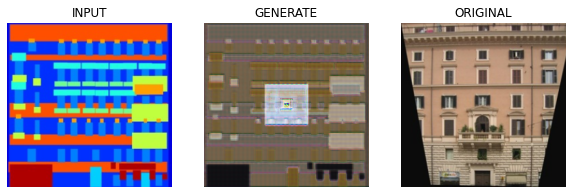

In [20]:
# let's train and validate

# fixed inputs
src_images_val, tgt_images_val = next(iter(val_loader))
src_images_val = src_images_val.to(device).float()
num_epochs = 1

import os
# checkpoints
if os.path.exists('/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-d.pytorch'):
    optimizerD.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-d.pytorch'))
    
if os.path.exists('/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-g.pytorch'):
    optimizerG.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-g.pytorch'))

if os.path.exists('/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-d.pytorch'):
    netD.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-d.pytorch'))

if os.path.exists('/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-g.pytorch'):
    netG.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-g.pytorch'))

num_steps = len(train_set) // batch_size

for epoch in range(num_epochs):
    
    d_loss = 0
    g_loss = 0
    
    for i, (src_images, tgt_images) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(K):
            
            d_loss += trainD(
                 src_images,
                 tgt_images
            )
        
        d_loss /= 2

        g_loss += trainG(src_images, tgt_images)

    
    # Log & save checkpoint only every X epochs
    if epoch % 10 == 0:
        
        # G & D Loss
        print("Epoch:{}, G Loss:{}, D Loss:{}".format(epoch, g_loss / num_steps, d_loss / num_steps))
        # save models
        torch.save(optimizerD.state_dict(), '/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-d.pytorch')
        torch.save(optimizerG.state_dict(), '/content/drive/MyDrive/DL_RL/section-6-pix2pix-optim-g.pytorch')
        torch.save(netD.state_dict(), '/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-d.pytorch')
        torch.save(netG.state_dict(), '/content/drive/MyDrive/DL_RL/section-6-pix2pix-network-g.pytorch')     
        generated = netG(src_images_val).detach().cpu()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
        ax1.title.set_text('INPUT')
        ax2.title.set_text('GENERATE')
        ax3.title.set_text('ORIGINAL')

        ax1.imshow(np.transpose((src_images_val.detach().cpu()[6] + 1) / 2, (1, 2, 0)))
        ax2.imshow(np.transpose((generated[6] + 1) / 2, (1, 2, 0)))
        ax3.imshow(np.transpose((tgt_images[6] + 1) / 2, (1, 2, 0)))
        plt.show()        

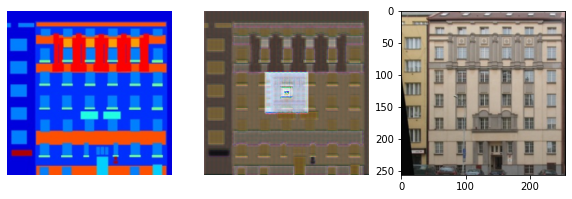

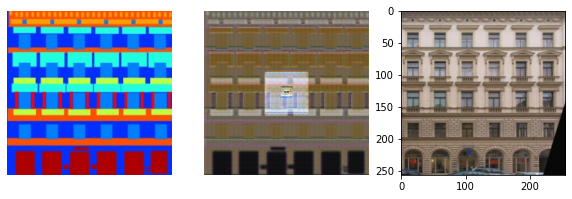

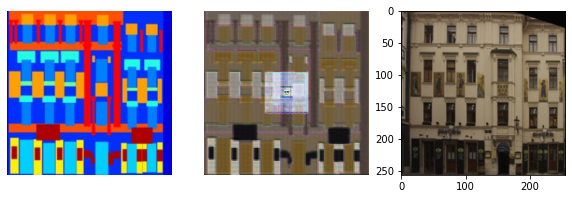

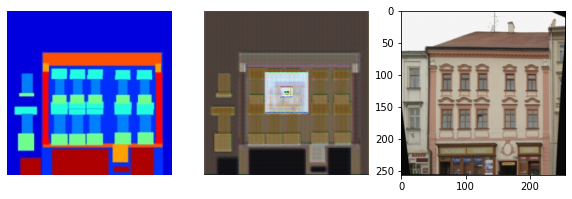

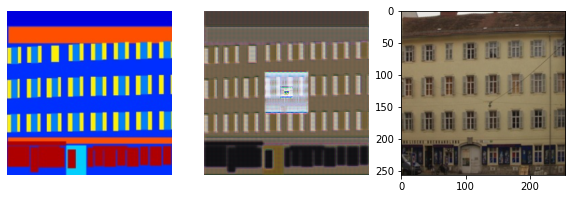

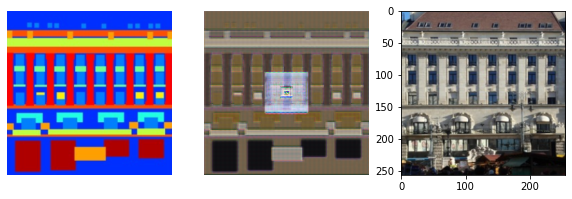

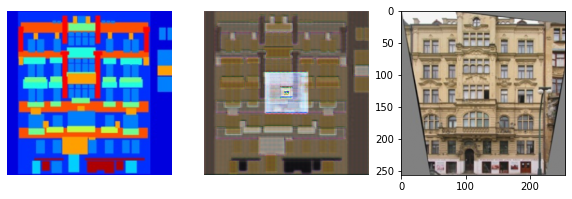

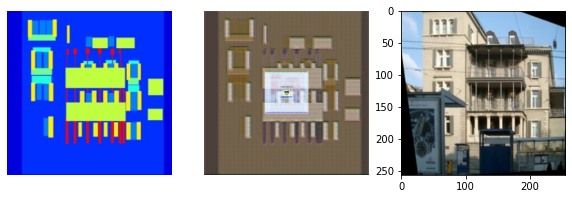

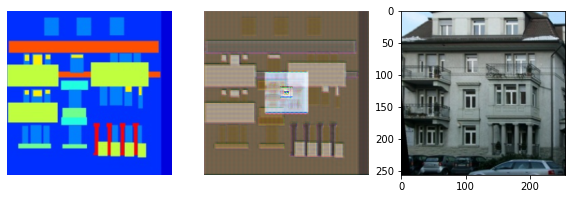

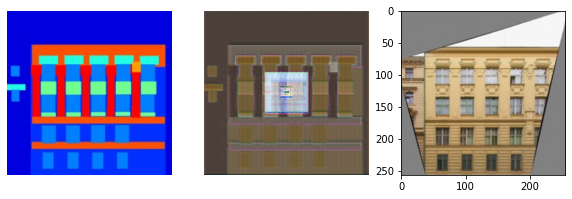

In [21]:


#load a batch
src_imgs, tgt_imgs = next(iter(test_loader))
src_imgs = src_imgs.to(device).float()

generated = netG(src_imgs).detach().cpu()

for i in range(10):
  generated = netG(src_imgs).detach().cpu()

# visualize batch
  fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 9))
  ax1.axis("off")
  ax2.axis("off")
  ax1.imshow(np.transpose((src_imgs.detach().cpu()[i] + 1) / 2, (1, 2, 0)))
  ax2.imshow(np.transpose((generated[i] + 1) / 2, (1, 2, 0)))
  ax3.imshow(np.transpose((tgt_imgs[i] + 1) / 2, (1, 2, 0)))

Обучал на колабе 80 эпох.
G Loss:58.22938537597656, D Loss:6.625201785936952e-05
При падение D Loss возрос лосс на Генераторе, затем со временем стал снижаться.
Значений для хороших результатов loss и сколько эпох учить для сравнения  в интернете пока найти не удалось. 

# Часть вторая: добавим циклы

Вторая часть — реализация CycleGAN. Предлагается на том же датасете реализовать базовую конструкцию CycleGAN для unpaired style transfer, то есть переноса стилей, каждый из которых задан неразмеченным датасетом




In [22]:
torch.cuda.empty_cache()

In [23]:
n_epochs=5
batch_size=2 # опять батч по видеопамяти не проходит, даже =32
lr=0.0002
decay_epoch=100
epoch = 0

In [24]:
# Data Loaders
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers
)

####References: https://github.com/Gokkulnath/FaceAgingGAN/blob/bbe0a202a2f9580344ffee865af915efbc179b9c/Dev_Notebook.ipynb

####https://github.com/stqc/AttentionGAN_JupyterNB/blob/b6df00e3068f3504d5ba13412cada6a1f2172dfd/AttentionGAN.ipynb

####https://github.com/accelsao/Machine-Learning-PlayGround/blob/d1766968e57026d85da446c266fe50b52a0b729e/CycleGAN.ipynb


####https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cyclegan/cyclegan.py

####https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [25]:
#CycleGAN uses Last 50 Images as buffer to stabilize the trainning process
#ReplayBuffer is a list that holds the last 50 generated images in a list
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [36]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [37]:
# Initialize generator and discriminator
netG_AB = Generator().to(device)
netG_BA = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_AB.parameters(), netG_BA.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))

real_labels = torch.ones(batch_size, 1, 30, 30).to(device)
fake_labels = torch.zeros(batch_size, 1, 30, 30).to(device)



In [38]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [39]:
# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

In [40]:
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

epoch 0 loss_G 1.6348342895507812 loss_G_identity 0.5022765100002289 loss_G_GAN 0.23332393169403076 loss_G_cycle 0.8992338180541992 loss_D 1.3247429706098046e-05


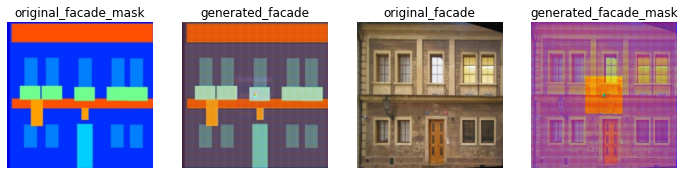

epoch 1 loss_G 1.5358242988586426 loss_G_identity 0.492571622133255 loss_G_GAN 0.17752147372812033 loss_G_cycle 0.8657312393188477 loss_D 4.682986627813079e-06


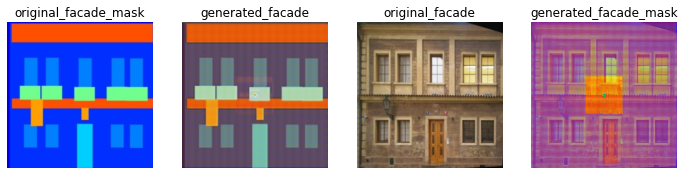

epoch 2 loss_G 1.4994462728500366 loss_G_identity 0.48410770297050476 loss_G_GAN 0.17483034543693066 loss_G_cycle 0.8405082523822784 loss_D 5.592617981164949e-06


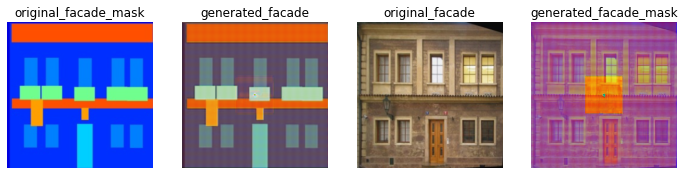

epoch 3 loss_G 1.5018119812011719 loss_G_identity 0.4895263612270355 loss_G_GAN 0.1814493639394641 loss_G_cycle 0.8308364152908325 loss_D 3.817307515419088e-06


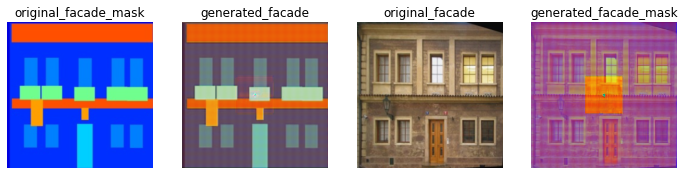

epoch 4 loss_G 1.507335901260376 loss_G_identity 0.48573754727840424 loss_G_GAN 0.20181076601147652 loss_G_cycle 0.8197875618934631 loss_D 4.337650352681521e-06


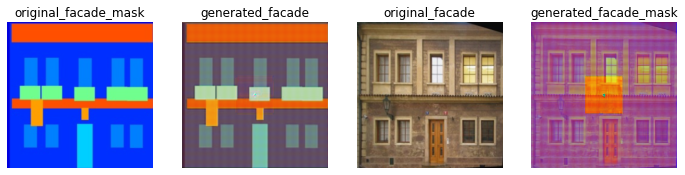

In [41]:
src_images_val, tgt_images_val = next(iter(val_loader))
src_images_val = src_images_val.to(device).float()
tgt_images_val = tgt_images_val.to(device).float()

import os
# checkpoints
if os.path.exists( '/content/drive/MyDrive/DL_RL/netG_AB.pytorch'):
    netG_AB.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/netG_AB.pytorch'))
    
if os.path.exists('/content/drive/MyDrive/DL_RL/netG_BA.pytorch'):
    netG_BA.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/netG_BA.pytorch'))

if os.path.exists('/content/drive/MyDrive/DL_RL/netD_A.pytorch'):
    netD_A.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/netD_A.pytorch'))

if os.path.exists('/content/drive/MyDrive/DL_RL/netD_B.pytorch'):
    netD_B.load_state_dict(torch.load('/content/drive/MyDrive/DL_RL/netD_B.pytorch'))


# https://github.com/Gokkulnath/FaceAgingGAN/blob/bbe0a202a2f9580344ffee865af915efbc179b9c/Dev_Notebook.ipynb

for epoch in range(n_epochs):
    for i, (real_A, real_B) in enumerate(train_loader):

        real_A = real_A.to(device).float()
        real_B = real_B.to(device).float()

        optimizer_G.zero_grad()

        # Identity loss
        same_B = netG_AB(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0

        same_A = netG_BA(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_AB(real_A)
        pred_fake = netD_B(torch.cat((real_B, fake_B), 1))
        loss_GAN_AB = criterion_GAN(pred_fake, real_labels)

        fake_A = netG_BA(real_B)
        pred_fake = netD_A(torch.cat((real_A, fake_A), 1))
        loss_GAN_BA = criterion_GAN(pred_fake, real_labels)

        # Cycle loss
        recovered_A = netG_BA(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_AB(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_AB + loss_GAN_BA + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()

        # Discriminator A
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(torch.cat((real_A, real_A), 1))
        loss_D_real = criterion_GAN(pred_real, real_labels)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(torch.cat((fake_A, fake_A), 1))
        loss_D_fake = criterion_GAN(pred_fake, fake_labels)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()

        # Discriminator B
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(torch.cat((real_B, real_B), 1))
        loss_D_real = criterion_GAN(pred_real, real_labels)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(torch.cat((fake_B, fake_B), 1))
        loss_D_fake = criterion_GAN(pred_fake, fake_labels)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        


    print('epoch', epoch, 'loss_G', loss_G.data.tolist(),
          'loss_G_identity', (loss_identity_A.data.tolist() + loss_identity_B.data.tolist()),
          'loss_G_GAN', (loss_GAN_AB.data.tolist() + loss_GAN_BA.data.tolist()),
          'loss_G_cycle', (loss_cycle_ABA.data.tolist() + loss_cycle_BAB.data.tolist()),
          'loss_D', (loss_D_A.data.tolist() + loss_D_B.data.tolist()))

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if epoch % 1 == 0:

      # save models
      torch.save(netG_AB.state_dict(), '/content/drive/MyDrive/DL_RL/netG_AB.pytorch')
      torch.save(netG_BA.state_dict(), '/content/drive/MyDrive/DL_RL/netG_BA.pytorch')
      torch.save(netD_A.state_dict(), '/content/drive/MyDrive/DL_RL/netD_A.pytorch')
      torch.save(netD_B.state_dict(), '/content/drive/MyDrive/DL_RL/netD_B.pytorch')
      
      fake_B = netG_AB(src_images_val).detach().cpu()
      fake_A = netG_BA(tgt_images_val).detach().cpu()
            
      fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 10))

      ax1.axis("off")
      ax2.axis("off")
      ax3.axis("off")
      ax4.axis("off")
      ax1.title.set_text('original_facade_mask')
      ax2.title.set_text('generated_facade')
      ax3.title.set_text('original_facade')
      ax4.title.set_text('generated_facade_mask')

      ax1.imshow(np.transpose((src_images_val.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
      ax2.imshow(np.transpose((fake_B.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
      ax3.imshow(np.transpose((tgt_images_val.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
      ax4.imshow(np.transpose((fake_A.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
      plt.show()

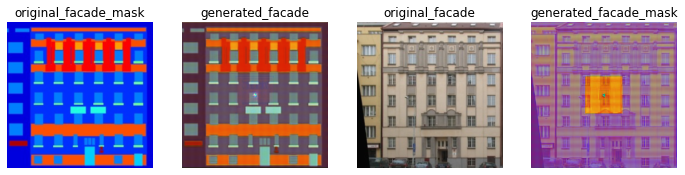

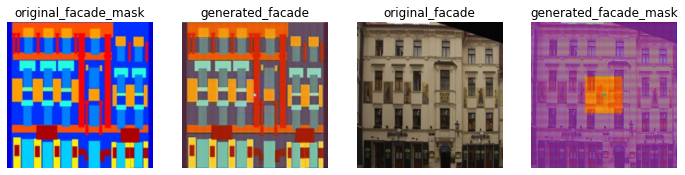

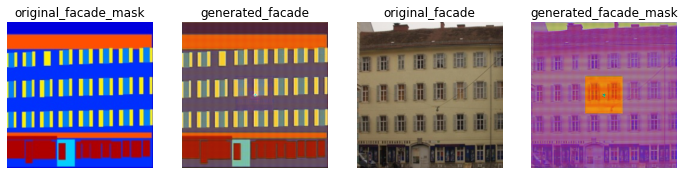

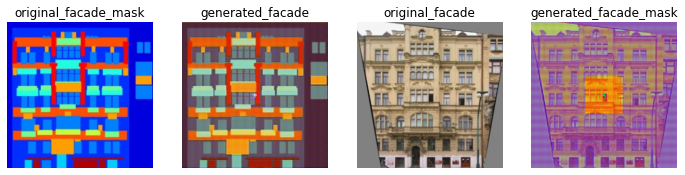

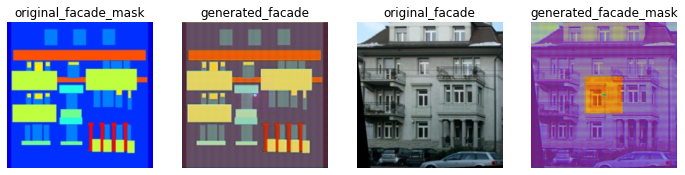

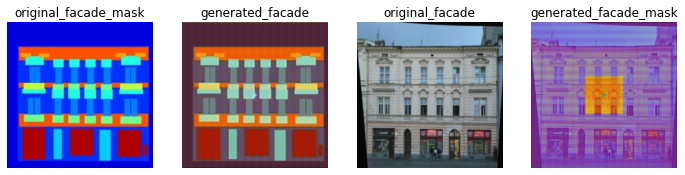

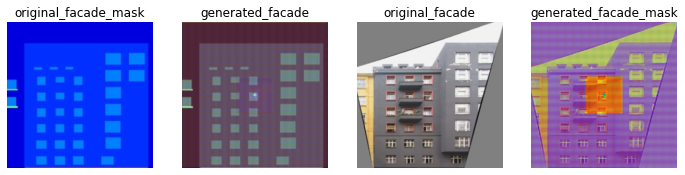

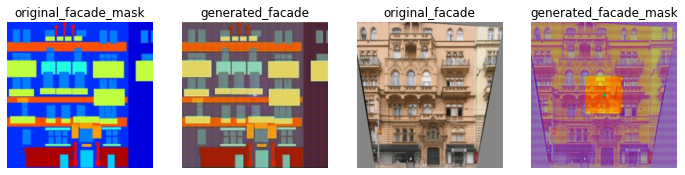

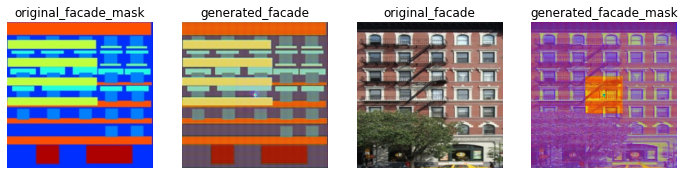

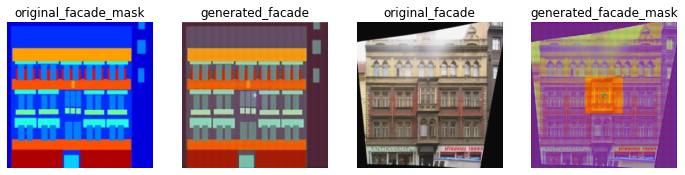

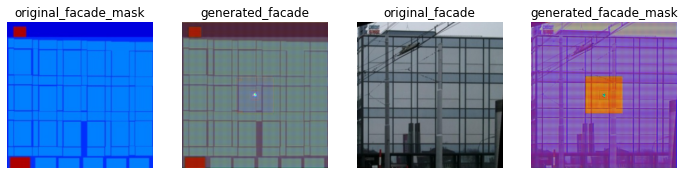

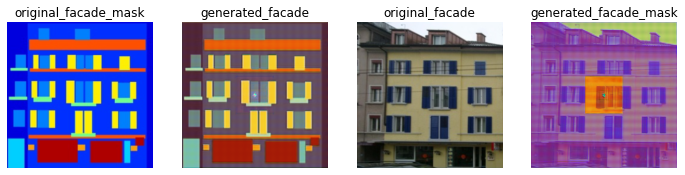

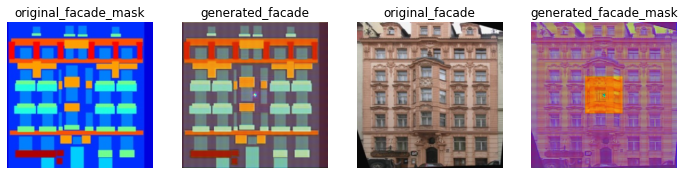

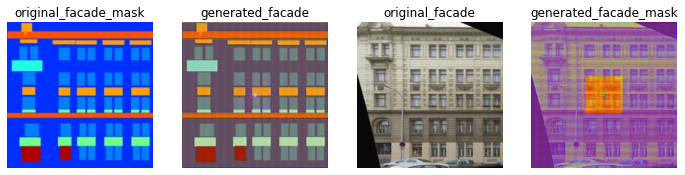

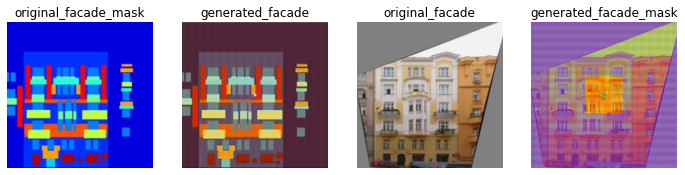

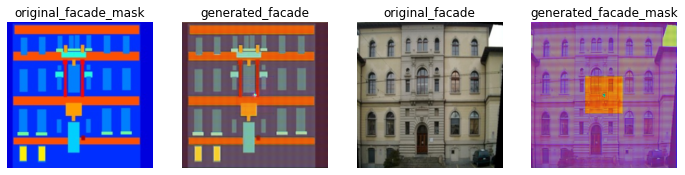

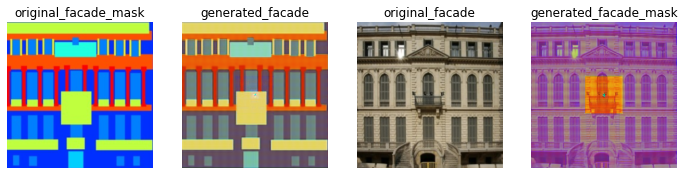

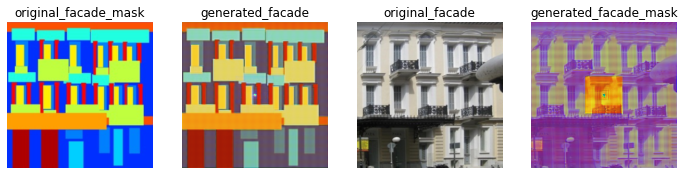

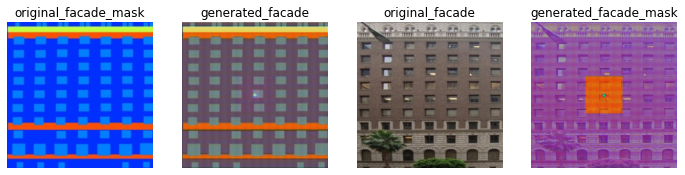

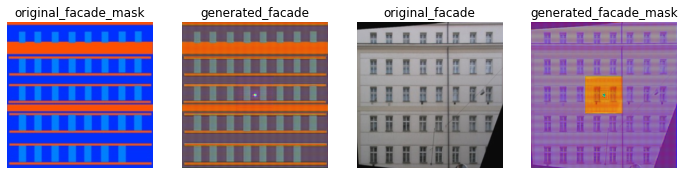

In [43]:
with torch.no_grad():

  for i, (real_A, real_B) in enumerate(test_loader):

    real_A = real_A.to(device).float()
    real_B = real_B.to(device).float()

    fake_B = netG_AB(real_A).detach().cpu()
    fake_A = netG_BA(real_B).detach().cpu()
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(12, 10))

    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")
    ax4.axis("off")
    ax1.title.set_text('original_facade_mask')
    ax2.title.set_text('generated_facade')
    ax3.title.set_text('original_facade')
    ax4.title.set_text('generated_facade_mask')

    ax1.imshow(np.transpose((real_A.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
    ax2.imshow(np.transpose((fake_B.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
    ax3.imshow(np.transpose((real_B.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
    ax4.imshow(np.transpose((fake_A.detach().cpu()[0] + 1) / 2, (1, 2, 0)))
    plt.show()

    if i == 19:
      break

На 20 эпохах обучения получилось loss_G 1.51 loss_G_identity 0.49 loss_G_GAN 0.20 loss_G_cycle 0.82 loss_D 4.3e-06

Обучается помедленнее, чем в предыдущем пункте. 